In [1]:
#matplotlib
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np

from cana.boolean_node import *
from cana.boolean_network import *

from utils import *
from modules import *
from mean_field_computations import *
from brute_force_computations import *
from simulations import *
from entropy_computations import *
from driver_sets import *

In [3]:
N=BooleanNetwork.from_file('../models/[id-091]__[var-12]__[in-4]__[MAPK-REDUCED-3].txt',file_type='logical')

In [4]:
dd={node.name: LUT_reduce(look_up_table(node)) for node in N.nodes}
sunits,sunit_map=get_sunits(N)
rsunit_map = reverse_sunit_map(sunit_map)
sunit_map

{0: 'v_DNA_damage-0',
 1: 'v_DNA_damage-1',
 2: 'v_FGFR3_stimulus-0',
 3: 'v_FGFR3_stimulus-1',
 4: 'v_TGFBR_stimulus-0',
 5: 'v_TGFBR_stimulus-1',
 6: 'v_EGFR_stimulus-0',
 7: 'v_EGFR_stimulus-1',
 8: 'v_Apoptosis-0',
 9: 'v_Apoptosis-1',
 10: 'v_ERK-0',
 11: 'v_ERK-1',
 12: 'v_GADD45-0',
 13: 'v_GADD45-1',
 14: 'v_GRB2-0',
 15: 'v_GRB2-1',
 16: 'v_Growth_Arrest-0',
 17: 'v_Growth_Arrest-1',
 18: 'v_JNK-0',
 19: 'v_JNK-1',
 20: 'v_MDM2-0',
 21: 'v_MDM2-1',
 22: 'v_PI3K-0',
 23: 'v_PI3K-1',
 24: 'v_PLCG-0',
 25: 'v_PLCG-1',
 26: 'v_Proliferation-0',
 27: 'v_Proliferation-1',
 28: 'v_RAS-0',
 29: 'v_RAS-1',
 30: 'v_p38-0',
 31: 'v_p38-1'}

In [5]:
def seed_name_to_sunit(name):
    return tuple(sorted(map(lambda sunit_name: rsunit_map[sunit_name], name)))

def sunit_name_to_str_seed(name):
    return str(seed_name_to_sunit((name,)))

def node_names_to_seeds(names):
    input_seed_names = set()
    for name in names:
        input_seed_names.add(name + '-0')
        input_seed_names.add(name + '-1')
    return set(map(sunit_name_to_str_seed, input_seed_names))

input_nodes = set(['v_DNA_damage', 'v_TGFBR_stimulus', 'v_EGFR_stimulus', 'v_FGFR3_stimulus'])
output_nodes = set(['v_Apoptosis', 'v_Growth_Arrest', 'v_Proliferation'])
all_nodes = set(map(lambda n: n.name, N.nodes))

input_seeds = node_names_to_seeds(input_nodes)
all_seeds = set(map(lambda n: str((n,)), sunits))

input_seeds, all_seeds, all_nodes

({'(0,)', '(1,)', '(2,)', '(3,)', '(4,)', '(5,)', '(6,)', '(7,)'},
 {'(0,)',
  '(1,)',
  '(10,)',
  '(11,)',
  '(12,)',
  '(13,)',
  '(14,)',
  '(15,)',
  '(16,)',
  '(17,)',
  '(18,)',
  '(19,)',
  '(2,)',
  '(20,)',
  '(21,)',
  '(22,)',
  '(23,)',
  '(24,)',
  '(25,)',
  '(26,)',
  '(27,)',
  '(28,)',
  '(29,)',
  '(3,)',
  '(30,)',
  '(31,)',
  '(4,)',
  '(5,)',
  '(6,)',
  '(7,)',
  '(8,)',
  '(9,)'},
 {'v_Apoptosis',
  'v_DNA_damage',
  'v_EGFR_stimulus',
  'v_ERK',
  'v_FGFR3_stimulus',
  'v_GADD45',
  'v_GRB2',
  'v_Growth_Arrest',
  'v_JNK',
  'v_MDM2',
  'v_PI3K',
  'v_PLCG',
  'v_Proliferation',
  'v_RAS',
  'v_TGFBR_stimulus',
  'v_p38'})

In [6]:
modules,translator=find_modules(N,1,sunits,sunit_map,modules={},translator={},
                seeds=set(map(eval, input_seeds)), reduced=True,ds=dd,
                pinning={},iterations=10,data=True,pin_start=True,
                update='synchronous',regenerate=False,models=1)

seed_entropy,_=seed_entropies(modules,seeds=input_seeds,normalized=True,data=False)
print "length:", len(seed_entropy)

seeds: 8
length: 8


In [7]:
def plot_entropies(entropies, sunit_map, translator, iterations):
    #graph predicted entropy over time
    t=iterations #iteration at which to compare seeds in order to sort them
    sorted_entropies=sorted(seed_entropy,key=lambda x: seed_entropy[x][t])
    print 'Lowest:',sorted_entropies[0],[round(seed_entropy[sorted_entropies[0]][t],2) for t in seed_entropy[sorted_entropies[0]]],
    print to_list(sorted_entropies[0],sunit_map,translator)
    print 'Highest:',sorted_entropies[-1],[round(seed_entropy[sorted_entropies[-1]][t],2) for t in seed_entropy[sorted_entropies[-1]]],
    print to_list(sorted_entropies[-1],sunit_map,translator)
    xvalues=range(iterations + 1)
    for index,seed in enumerate(sorted_entropies):
        plt.plot(xvalues,[seed_entropy[seed][t] for t in xvalues],label=str(to_list(seed,sunit_map,translator))+', '+str(seed))
    plt.title("Entropy over time",fontsize=18)
    plt.ylabel("entropy",fontsize=16)
    plt.xlabel("time",fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim([0,iterations])
    plt.legend(bbox_to_anchor=(1.0, 0.95),fontsize=14)

Lowest: (5,) [0.94, 0.62, 0.35, 0.22, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19] ['v_TGFBR_stimulus-1']
Highest: (4,) [0.94, 0.79, 0.8, 0.74, 0.76, 0.71, 0.74, 0.7, 0.73, 0.7, 0.73] ['v_TGFBR_stimulus-0']


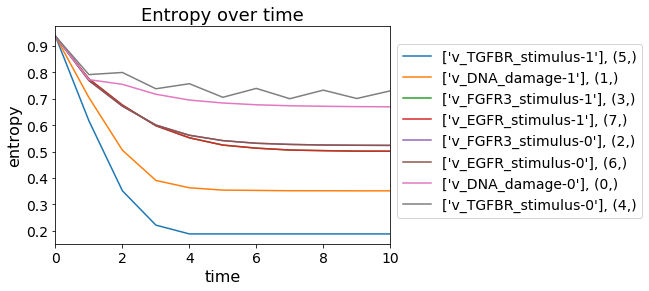

In [8]:
plot_entropies(seed_entropy, sunit_map, translator, 10)

length: 8
Lowest: (5,) [1.0, 0.57, 0.22, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] ['v_TGFBR_stimulus-1']
Highest: (4,) [1.0, 0.81, 0.82, 0.73, 0.76, 0.69, 0.74, 0.68, 0.73, 0.69, 0.72] ['v_TGFBR_stimulus-0']


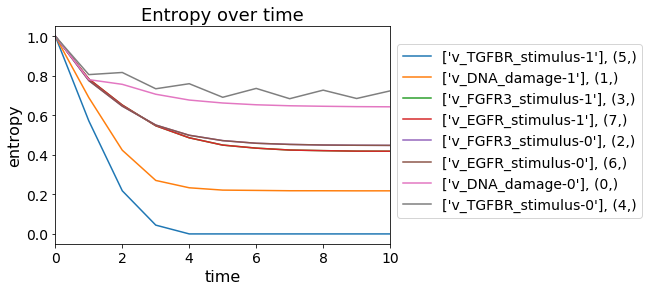

In [9]:
seed_entropy,_=seed_entropies(modules,seeds=input_seeds,nodes=all_nodes - input_nodes, normalized=True,data=False)
print "length:", len(seed_entropy)
plot_entropies(seed_entropy, sunit_map, translator, 10)

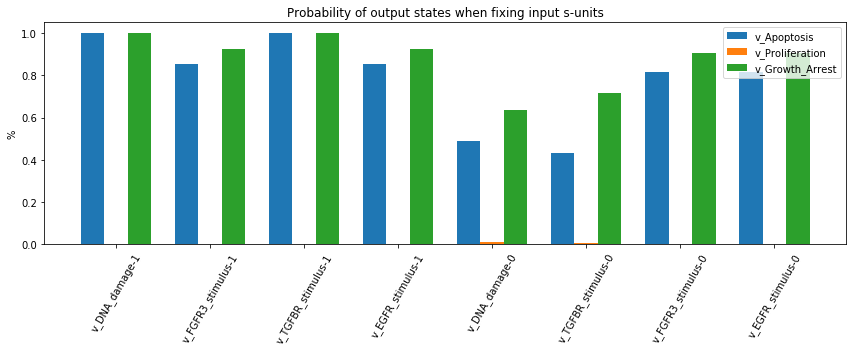

In [10]:
labels = []
data = {node: [] for node in output_nodes}

for seed in input_seeds:
    #print to_list(seed, sunit_map, translator)
    labels.append(to_list(seed, sunit_map, translator)[0])
    probs = modules[seed][10]
    for node in output_nodes:
        #print node, probs[node]
        data[node].append(probs[node])
    
#print labels, data

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 5))
rects = []
for i, node in enumerate(output_nodes):
    rects.append(ax.bar(x - (len(output_nodes) / 2. - i - 0.5) * width, data[node], width, label=node))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('%')
ax.set_title('Probability of output states when fixing input s-units')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=60)
ax.legend()

fig.tight_layout()

plt.show()

In [11]:
start_time = time.time()

selections, entropies=top_selection(N,sunits,sunit_map,modules,translator,seeds=input_seeds,max_s=10,
                                    top=1,reduced=True,ds=dd,iterations=10,attractor=None,attractors=None,
                                    force=False,pin_start=True,update='synchronous',regenerate=False,
                                    drivers=True)

for seed in selections:
    print(seed, entropies[seed], to_list(seed,sunit_map,translator))

driver = reduce_selection(selections[-1],N,sunits,sunit_map,modules,translator,reduced=True,ds=dd,t=10) #reduce the final selection

print driver
print "--- Total time: %s seconds ---" % (time.time() - start_time)

('()', 0.574536503426056, [])
('(5,)', 0.1875, ['v_TGFBR_stimulus-1'])
('(1, 5)', 0.125, ['v_DNA_damage-1', 'v_TGFBR_stimulus-1'])
('(1, 5, 6)', 0.0625, ['v_DNA_damage-1', 'v_TGFBR_stimulus-1', 'v_EGFR_stimulus-0'])
('(1, 2, 5, 6)', 0.0, ['v_DNA_damage-1', 'v_FGFR3_stimulus-0', 'v_TGFBR_stimulus-1', 'v_EGFR_stimulus-0'])
(1, 2, 5, 6)
--- Total time: 2.14343714714 seconds ---


In [12]:
modules['(1, 2, 5, 6)'][10]

{'v_Apoptosis': 1.0,
 'v_DNA_damage': 1.0,
 'v_EGFR_stimulus': 0.0,
 'v_ERK': 0.0,
 'v_FGFR3_stimulus': 0.0,
 'v_GADD45': 1.0,
 'v_GRB2': 1.0,
 'v_Growth_Arrest': 1.0,
 'v_JNK': 1.0,
 'v_MDM2': 0.0,
 'v_PI3K': 1.0,
 'v_PLCG': 0.0,
 'v_Proliferation': 0.0,
 'v_RAS': 1.0,
 'v_TGFBR_stimulus': 1.0,
 'v_p38': 1.0}

In [13]:
def top_selection_adjusted(N,sunits,sunit_map,modules={},translator={},seeds=None,max_s=10,top=1,reduced=False,ds=None,pinning={},tau=0.0,
        iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,attractor=None,attractors=None,pin_start=True,
        force=False,update='synchronous',order=None,regenerate=False,models=1,drivers=False,names='string',start_seed=(),
        output_nodes=None):
    """ determines seed selection across seed sizes to most reduce entropy in the system, 
    considers the top x per seed size s; returns selections and the entropies dictionary 
    if attractor is given (requires attractors dictionary), only considers seeds that may resolve in that attractor 
    t is the iteration to compare entropies on
    seeds specifies which nodes to use to try to reduce entropy in the network (e.g. all or fvs only)
    drivers = True allows for early exit of the function to return the selection once it reaches zero entropy
    set names = 'string' for biological networks, 'int' for RBNs
    start_seed allows the selection to start with a given seed (e.g. input nodes), pass as a tuple """

    if not seeds:
        if not modules:
            modules,translator=find_modules(N,1,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,
                        iterations=iterations,data=True,seeds=None,p=unknown_prob,verbose=False,pin_start=pin_start,
                        update=update,order=order,regenerate=regenerate,names=names)
        seeds=reduce_seeds(modules,sunit_map,translator,length=1) #all s-units in the network
    start_length=len(to_list(start_seed,sunit_map,translator))
    candidates,selections=set([str(start_seed)]),[str(start_seed)] #top level candidates to reduce entropy; starts with no selection by default
    diffusion=find_modules(N,start_length,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,iterations=iterations,
        data=True,seeds=[start_seed],p=unknown_prob,verbose=False,pin_start=pin_start,update=update,order=order,regenerate=regenerate,names=names)[0][str(start_seed)]
    seed_entropy,seed_configs=config_entropy(diffusion,nodes=output_nodes,base=base,normalized=normalized)
    entropies={str(start_seed): seed_entropy[t]}
    if drivers and entropies[str(start_seed)]==0: #early exit if start seed is a driver set
        return selections,entropies
    #print len(modules),len(translator)

    for s in range(start_length+1,max_s+1):
        for module in candidates:
            for single in seeds:
                neg,pos=int(translator[single][0]/2)*2,int(translator[single][0]/2)*2+1 #OFF and ON state; assumes binary!
                if neg in translator[module] or pos in translator[module]: continue #repetition or contradiction
                seed=tuple(sorted(set(translator[module]).union(set(translator[single]))))
                if not str(seed) in modules:
                    modules,translator=find_modules(N,s,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,
                            iterations=iterations,data=True,seeds=[seed],p=unknown_prob,verbose=False,pin_start=pin_start,
                            update=update,order=order,regenerate=regenerate,names=names)
                if attractor: #skip all seeds that won't resolve in the given attractor
                    sunit_set=resolved_sunits(modules[str(seed)][t],tau=tau)
                    if type(attractor)==str: #represents a fixed point
                        if not attractor_is_reachable(sunit_set,attractors,attractor): continue
                    else:
                        lc_configs={a:attractors[attractor][i] for i,a in enumerate(attractor)}
                        #print [lc_configs[a] for a in attractor],sum([attractor_is_reachable(sunit_set,lc_configs,a) for a in attractor])
                        if sum([attractor_is_reachable(sunit_set,lc_configs,a) for a in attractor])<len(attractor):
                            continue #checks every config in limit cycle (s-units must be fixed in all attractor configs)
                seed_entropy,seed_configs=config_entropy(modules[str(seed)],nodes=output_nodes,base=base,normalized=normalized)
                entropies[str(seed)]=seed_entropy[t] #select based on final entropy if t=iterations
        if force: #enforce selection every iteration; will be random if new node does not reduce entropy
            candidates=reduce_seeds(entropies,sunit_map,translator,length=s) #force a new selection every iteration
            candidates=set(sorted(candidates,key=lambda x: entropies[x])[:top])
        else: 
            candidates=set(sorted(entropies,key=lambda x: entropies[x])[:top])
        if candidates:
            min_candidate=min(candidates,key=lambda x: entropies[x])
            selections.append(min_candidate) #select the one with lowest entropy
            if drivers and min_candidate in entropies and entropies[min_candidate]==0:
                return selections,entropies #early exit in looking for driver sets
        #print [to_list(seed,sunit_map,translator) for seed in sorted(entropies,key=lambda x: entropies[x])[:top]]
        #for seed in candidates: print s,candidates,selections,entropies[seed] #,sorted(entropies,key=lambda x: entropies[x]),
    return selections,entropies

In [14]:
#reduce given seed to a set of driver nodes; goal is to find minimal sets that reach an attractor or target entropy
def reduce_selection_adjusted(seed,N,sunits,sunit_map,modules={},translator={},reduced=False,ds=None,pinning={},
                     iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,pin_start=True,
                     update='synchronous',order=None,regenerate=False,names='string', output_nodes=None):
    """ reduce seed in modules to a subset by removing any nodes that do not increase entropy when removed,
    checks entropy at the specified time step t, returns the reduced set as a seed (tuple)
    NOTE: seed must be passed as a list if it's not in translator """
    
    if not str(seed) in modules or not modules[str(seed)]: #check for missing or empty modules
        #NOTE: s arbitrarily set to 1 in find_modules because its value doesn't matter
        modules,translator=find_modules(N,1,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,
                        iterations=iterations,data=True,seeds=[seed],p=unknown_prob,verbose=False,pin_start=pin_start,
                            update=update,order=order,regenerate=regenerate,names=names)
    seed_entropy,seed_configs=config_entropy(modules[str(seed)],nodes=output_nodes,base=base,normalized=normalized)
    min_entropy=seed_entropy[t] #select based on final entropy if t=iterations
    seed=translator[str(seed)] #force seed to be in list form
    
    #test removing nodes one by one
    drivers=set([])
    removed=set([]) #alternatively, remove sunits sequentially from the seed
    for sunit in seed:
        alt_seed=tuple(sorted(set(seed)-{sunit}-removed)) #updated to remove sequentially
        #print seed,sunit,alt_seed
        if not str(alt_seed) in modules or not modules[str(alt_seed)]: #check for missing or empty modules
            modules,translator=find_modules(N,1,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,
                    iterations=iterations,data=True,seeds=[alt_seed],p=unknown_prob,verbose=False,pin_start=pin_start,
                    update=update,order=order,regenerate=regenerate,names=names)
        seed_entropy,seed_configs=config_entropy(modules[str(alt_seed)],nodes=output_nodes,base=base,normalized=normalized)
        if seed_entropy[t]>min_entropy: #this is a driver node because it reduces entropy
            drivers.add(sunit)
        else: #alternative
            removed.add(sunit)
    return tuple(sorted(drivers)) #note that this should already be sorted

In [15]:
start_time = time.time()

selections, entropies=top_selection_adjusted(N,sunits,sunit_map,modules,translator,seeds=input_seeds,max_s=10,
                                    top=1,reduced=True,ds=dd,iterations=10,attractor=None,attractors=None,
                                    force=False,pin_start=True,update='synchronous',regenerate=False,
                                    drivers=True, output_nodes=all_nodes - input_nodes)

for seed in selections:
    print(seed, entropies[seed], to_list(seed,sunit_map,translator))

driver = reduce_selection_adjusted(selections[-1],N,sunits,sunit_map,modules,translator,reduced=True,ds=dd,
                          t=10, output_nodes=all_nodes - input_nodes) #reduce the final selection

print driver
print "--- Total time: %s seconds ---" % (time.time() - start_time)

('()', 0.4327153379014081, [])
('(5,)', 0.0, ['v_TGFBR_stimulus-1'])
(5,)
--- Total time: 0.239518880844 seconds ---


In [16]:
modules['(5,)'][10]

{'v_Apoptosis': 1.0,
 'v_DNA_damage': 0.5,
 'v_EGFR_stimulus': 0.5,
 'v_ERK': 0.0,
 'v_FGFR3_stimulus': 0.5,
 'v_GADD45': 1.0,
 'v_GRB2': 1.0,
 'v_Growth_Arrest': 1.0,
 'v_JNK': 1.0,
 'v_MDM2': 0.0,
 'v_PI3K': 1.0,
 'v_PLCG': 0.0,
 'v_Proliferation': 0.0,
 'v_RAS': 1.0,
 'v_TGFBR_stimulus': 1.0,
 'v_p38': 1.0}

In [17]:
start_time = time.time()

selections, entropies=top_selection_adjusted(N,sunits,sunit_map,modules,translator,
                                    seeds=input_seeds - set(map(lambda x: str(seed_name_to_sunit(x)), [('v_TGFBR_stimulus-1',)])),
                                    max_s=10,top=1,reduced=True,ds=dd,iterations=10,attractor=None,attractors=None,
                                    force=False,pin_start=True,update='synchronous',regenerate=False,
                                    drivers=True, output_nodes=all_nodes - input_nodes)

for seed in selections:
    print(seed, entropies[seed], to_list(seed,sunit_map,translator))

driver = reduce_selection_adjusted(selections[-1],N,sunits,sunit_map,modules,translator,reduced=True,ds=dd,
                          t=10, output_nodes=all_nodes - input_nodes) #reduce the final selection

print driver
print "--- Total time: %s seconds ---" % (time.time() - start_time)

('()', 0.4327153379014081, [])
('(1,)', 0.21795429163221727, ['v_DNA_damage-1'])
('(1, 6)', 0.2140911594647782, ['v_DNA_damage-1', 'v_EGFR_stimulus-0'])
('(1, 2, 6)', 0.16709277329759722, ['v_DNA_damage-1', 'v_FGFR3_stimulus-0', 'v_EGFR_stimulus-0'])
('(1, 2, 4, 6)', 0.05845033181851006, ['v_DNA_damage-1', 'v_FGFR3_stimulus-0', 'v_TGFBR_stimulus-0', 'v_EGFR_stimulus-0'])
('(1, 2, 4, 6)', 0.05845033181851006, ['v_DNA_damage-1', 'v_FGFR3_stimulus-0', 'v_TGFBR_stimulus-0', 'v_EGFR_stimulus-0'])
('(1, 2, 4, 6)', 0.05845033181851006, ['v_DNA_damage-1', 'v_FGFR3_stimulus-0', 'v_TGFBR_stimulus-0', 'v_EGFR_stimulus-0'])
('(1, 2, 4, 6)', 0.05845033181851006, ['v_DNA_damage-1', 'v_FGFR3_stimulus-0', 'v_TGFBR_stimulus-0', 'v_EGFR_stimulus-0'])
('(1, 2, 4, 6)', 0.05845033181851006, ['v_DNA_damage-1', 'v_FGFR3_stimulus-0', 'v_TGFBR_stimulus-0', 'v_EGFR_stimulus-0'])
('(1, 2, 4, 6)', 0.05845033181851006, ['v_DNA_damage-1', 'v_FGFR3_stimulus-0', 'v_TGFBR_stimulus-0', 'v_EGFR_stimulus-0'])
('(1, 2, 4,

In [18]:
final_state = modules['(1, 2, 4, 6)'][10]
final_state

{'v_Apoptosis': 0.999999987755518,
 'v_DNA_damage': 1.0,
 'v_EGFR_stimulus': 0.0,
 'v_ERK': 4.0529095219969046e-26,
 'v_FGFR3_stimulus': 0.0,
 'v_GADD45': 0.9999999999999847,
 'v_GRB2': 0.0,
 'v_Growth_Arrest': 0.9999999999999847,
 'v_JNK': 0.9999999999626463,
 'v_MDM2': 1.2244463871023125e-08,
 'v_PI3K': 0.810032579966371,
 'v_PLCG': 1.1380670333456316e-19,
 'v_Proliferation': 1.4086733715025746e-33,
 'v_RAS': 1.3100631690576847e-14,
 'v_TGFBR_stimulus': 0.0,
 'v_p38': 0.9999999999626463}

In [19]:
final_input_units = set()
for node in input_nodes:
    final_input_units.add(node + '-0' if final_state[node] == 0.0 else node + '-1')
final_input_units

{'v_DNA_damage-1',
 'v_EGFR_stimulus-0',
 'v_FGFR3_stimulus-0',
 'v_TGFBR_stimulus-0'}

In [20]:
attractors=attractors_to_dict(N)
len(attractors), attractors

(20,
 {'0000000000000000': {'v_Apoptosis-0',
   'v_DNA_damage-0',
   'v_EGFR_stimulus-0',
   'v_ERK-0',
   'v_FGFR3_stimulus-0',
   'v_GADD45-0',
   'v_GRB2-0',
   'v_Growth_Arrest-0',
   'v_JNK-0',
   'v_MDM2-0',
   'v_PI3K-0',
   'v_PLCG-0',
   'v_Proliferation-0',
   'v_RAS-0',
   'v_TGFBR_stimulus-0',
   'v_p38-0'},
  '0000000000110000': {'v_Apoptosis-0',
   'v_DNA_damage-0',
   'v_EGFR_stimulus-0',
   'v_ERK-0',
   'v_FGFR3_stimulus-0',
   'v_GADD45-0',
   'v_GRB2-0',
   'v_Growth_Arrest-0',
   'v_JNK-0',
   'v_MDM2-1',
   'v_PI3K-1',
   'v_PLCG-0',
   'v_Proliferation-0',
   'v_RAS-0',
   'v_TGFBR_stimulus-0',
   'v_p38-0'},
  '0010101111010011': {'v_Apoptosis-1',
   'v_DNA_damage-0',
   'v_EGFR_stimulus-0',
   'v_ERK-0',
   'v_FGFR3_stimulus-0',
   'v_GADD45-1',
   'v_GRB2-1',
   'v_Growth_Arrest-1',
   'v_JNK-1',
   'v_MDM2-0',
   'v_PI3K-1',
   'v_PLCG-0',
   'v_Proliferation-0',
   'v_RAS-1',
   'v_TGFBR_stimulus-1',
   'v_p38-1'},
  '0011101111010011': {'v_Apoptosis-1',
   '

In [21]:
for name, attractor in attractors.items():
    if isinstance(attractor, list):
        for attr in attractor:
            if attr.intersection(final_input_units) == final_input_units:
                print name, attractor
    elif attractor.intersection(final_input_units) == final_input_units:
        print name, attractor

1000101011000001 set(['v_Proliferation-0', 'v_DNA_damage-1', 'v_RAS-0', 'v_PI3K-0', 'v_PLCG-0', 'v_GADD45-1', 'v_TGFBR_stimulus-0', 'v_Growth_Arrest-1', 'v_Apoptosis-1', 'v_JNK-1', 'v_FGFR3_stimulus-0', 'v_p38-1', 'v_MDM2-0', 'v_GRB2-0', 'v_EGFR_stimulus-0', 'v_ERK-0'])
1000101011010001 set(['v_Proliferation-0', 'v_DNA_damage-1', 'v_RAS-0', 'v_PLCG-0', 'v_PI3K-1', 'v_GADD45-1', 'v_TGFBR_stimulus-0', 'v_Growth_Arrest-1', 'v_Apoptosis-1', 'v_JNK-1', 'v_FGFR3_stimulus-0', 'v_p38-1', 'v_MDM2-0', 'v_GRB2-0', 'v_EGFR_stimulus-0', 'v_ERK-0'])


In [22]:
final_state['v_PI3K']

0.810032579966371

In [23]:
attractors_simple = dict()
for attr in attractors:
    if isinstance(attr, str):
        attractors_simple[attr] = attractors[attr]

len(attractors_simple), attractors_simple

(12,
 {'0000000000000000': {'v_Apoptosis-0',
   'v_DNA_damage-0',
   'v_EGFR_stimulus-0',
   'v_ERK-0',
   'v_FGFR3_stimulus-0',
   'v_GADD45-0',
   'v_GRB2-0',
   'v_Growth_Arrest-0',
   'v_JNK-0',
   'v_MDM2-0',
   'v_PI3K-0',
   'v_PLCG-0',
   'v_Proliferation-0',
   'v_RAS-0',
   'v_TGFBR_stimulus-0',
   'v_p38-0'},
  '0000000000110000': {'v_Apoptosis-0',
   'v_DNA_damage-0',
   'v_EGFR_stimulus-0',
   'v_ERK-0',
   'v_FGFR3_stimulus-0',
   'v_GADD45-0',
   'v_GRB2-0',
   'v_Growth_Arrest-0',
   'v_JNK-0',
   'v_MDM2-1',
   'v_PI3K-1',
   'v_PLCG-0',
   'v_Proliferation-0',
   'v_RAS-0',
   'v_TGFBR_stimulus-0',
   'v_p38-0'},
  '0010101111010011': {'v_Apoptosis-1',
   'v_DNA_damage-0',
   'v_EGFR_stimulus-0',
   'v_ERK-0',
   'v_FGFR3_stimulus-0',
   'v_GADD45-1',
   'v_GRB2-1',
   'v_Growth_Arrest-1',
   'v_JNK-1',
   'v_MDM2-0',
   'v_PI3K-1',
   'v_PLCG-0',
   'v_Proliferation-0',
   'v_RAS-1',
   'v_TGFBR_stimulus-1',
   'v_p38-1'},
  '0011101111010011': {'v_Apoptosis-1',
   '

In [24]:
#find driver set for all attractors
iterations=10 #how long to run the IBMFA
t=iterations #at which iteration to compare entropy when making selections
drivers={}
for i,attractor in enumerate(attractors_simple):
    selection=driver_selection(N,sunits,sunit_map,modules,translator, seeds=input_seeds,attractor=attractor,
                               attractors=attractors_simple,iterations=iterations,t=t,
                               update='synchronous',order=None,regenerate=False)
    drivers[i]=selection
    print i,attractor
    if selection:
        print selection,to_list(selection,sunit_map)
    else:
        print None

0 1010101111010011
(1, 2, 5, 6) ['v_DNA_damage-1', 'v_FGFR3_stimulus-0', 'v_TGFBR_stimulus-1', 'v_EGFR_stimulus-0']
1 1011101111010011
(1, 2, 5, 7) ['v_DNA_damage-1', 'v_FGFR3_stimulus-0', 'v_TGFBR_stimulus-1', 'v_EGFR_stimulus-1']
2 1000101011010001
None
3 0011101111010011
(0, 2, 5, 7) ['v_DNA_damage-0', 'v_FGFR3_stimulus-0', 'v_TGFBR_stimulus-1', 'v_EGFR_stimulus-1']
4 0010101111010011
(0, 2, 5, 6) ['v_DNA_damage-0', 'v_FGFR3_stimulus-0', 'v_TGFBR_stimulus-1', 'v_EGFR_stimulus-0']
5 0110101111010011
(0, 3, 5, 6) ['v_DNA_damage-0', 'v_FGFR3_stimulus-1', 'v_TGFBR_stimulus-1', 'v_EGFR_stimulus-0']
6 0111101111010011
(0, 3, 5, 7) ['v_DNA_damage-0', 'v_FGFR3_stimulus-1', 'v_TGFBR_stimulus-1', 'v_EGFR_stimulus-1']
7 1000101011000001
None
8 0000000000110000
None
9 0000000000000000
None
10 1111101111010011
(1, 3, 5, 7) ['v_DNA_damage-1', 'v_FGFR3_stimulus-1', 'v_TGFBR_stimulus-1', 'v_EGFR_stimulus-1']
11 1110101111010011
(1, 3, 5, 6) ['v_DNA_damage-1', 'v_FGFR3_stimulus-1', 'v_TGFBR_stimulus

In [25]:
def driver_selection_adjusted(N,sunits,sunit_map,modules={},translator={},seeds=None,max_s=10,top=1,reduced=False,ds=None,pinning={},tau=0.0,
    iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,attractor=None,attractors=None,pin_start=True,force=False,
        update='synchronous',order=None,regenerate=False,names='string',start_seed=(),output_nodes=None):
    """ return the driver set if possible based on the top selection greedy heuristic"""

    selections,entropies=top_selection_adjusted(N,sunits,sunit_map,modules,translator,seeds=seeds,max_s=max_s,top=top,reduced=reduced,ds=ds,
        pinning=pinning,tau=tau,iterations=iterations,unknown_prob=unknown_prob,t=t,base=base,normalized=normalized,attractor=attractor,
        attractors=attractors,pin_start=pin_start,force=force,update=update,order=order,regenerate=regenerate,drivers=True,names=names,
        start_seed=start_seed, output_nodes=output_nodes)
    # print selections,entropies
    for seed in selections: 
        if entropies[seed]==0.0:
            rs=reduce_selection_adjusted(seed,N,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,t=t,
                iterations=iterations,pin_start=pin_start,update=update,order=order,
                regenerate=regenerate,names=names, output_nodes=output_nodes)
            return rs


In [26]:
#find driver set for all attractors
iterations=10 #how long to run the IBMFA
t=iterations #at which iteration to compare entropy when making selections
drivers={}
for i,attractor in enumerate(attractors_simple):
    selection=driver_selection_adjusted(N,sunits,sunit_map,modules,translator, seeds=input_seeds,attractor=attractor,
                               attractors=attractors_simple,iterations=iterations,t=t,
                               update='synchronous',order=None,regenerate=False,
                               output_nodes=all_nodes - input_nodes)
    drivers[i]=selection
    print i,attractor
    if selection:
        print selection,to_list(selection,sunit_map)
    else:
        print None

0 1010101111010011
(5,) ['v_TGFBR_stimulus-1']
1 1011101111010011
(5,) ['v_TGFBR_stimulus-1']
2 1000101011010001
None
3 0011101111010011
(5,) ['v_TGFBR_stimulus-1']
4 0010101111010011
(5,) ['v_TGFBR_stimulus-1']
5 0110101111010011
(5,) ['v_TGFBR_stimulus-1']
6 0111101111010011
(5,) ['v_TGFBR_stimulus-1']
7 1000101011000001
None
8 0000000000110000
None
9 0000000000000000
None
10 1111101111010011
(5,) ['v_TGFBR_stimulus-1']
11 1110101111010011
(5,) ['v_TGFBR_stimulus-1']
